In the previous file, you created an MCP research server that exposes 2 tools. In this lesson, you will make the chatbot communicate to the server through an MCP client. This will make the chatbot MCP compatible. You will continue from where you left off in lesson 4, i.e., you are provided again with the `mcp_project` folder that contains the `research_server.py` file. You'll add to it the MCP chatbot file and update the environment. 

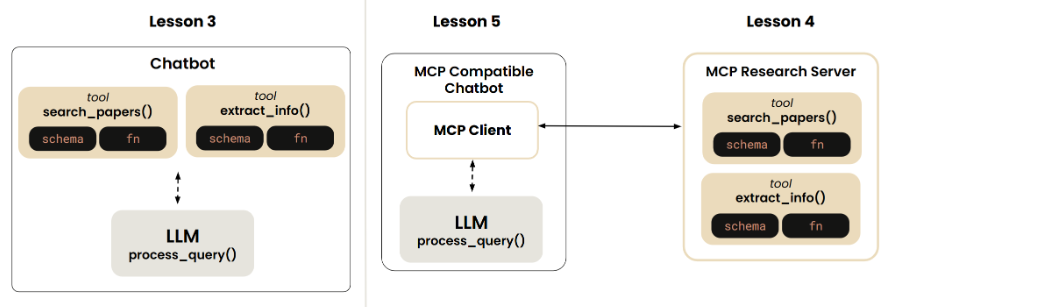

## Back to the Chatbot Example

Here are the main code parts (`process_query`, `chat_loop`) from the chatbot example of lesson 3. Notice that the burden of tool definitions and execution is now shifted onto the MCP server, so the chatbot logic only contains code related to processing the user queries and to keeping the chat loop running until the user types `quit`.

In [1]:
from dotenv import load_dotenv
import anthropic

load_dotenv()
anthropic = anthropic.Anthropic()

def process_query(query):
    messages = [{'role':'user', 'content':query}]
    response = anthropic.messages.create(max_tokens = 2024,
                                  model = 'claude-3-7-sonnet-20250219', 
                                  tools = tools,
                                  messages = messages)
    process_query = True
    while process_query:
        assistant_content = []
        for content in response.content:
            if content.type =='text':
                print(content.text)
                assistant_content.append(content)
                if(len(response.content)==1):
                    process_query= False
            elif content.type == 'tool_use':
                assistant_content.append(content)
                messages.append({'role':'assistant', 'content':assistant_content})
                tool_id = content.id
                tool_args = content.input
                tool_name = content.name

                print(f"Calling tool {tool_name} with args {tool_args}")
                
                # Call a tool
                result = execute_tool(tool_name, tool_args)
                messages.append({"role": "user", 
                                  "content": [
                                      {
                                          "type": "tool_result",
                                          "tool_use_id":tool_id,
                                          "content": result
                                      }
                                  ]
                                })
                response = anthropic.messages.create(max_tokens = 2024,
                                  model = 'claude-3-7-sonnet-20250219', 
                                  tools = tools,
                                  messages = messages) 
                
                if(len(response.content)==1 and response.content[0].type == "text"):
                    print(response.content[0].text)
                    process_query= False


def chat_loop():
    print("Type your queries or 'quit' to exit.")
    while True:
        try:
            query = input("\nQuery: ").strip()
            if query.lower() == 'quit':
                break
    
            process_query(query)
            print("\n")
        except Exception as e:
            print(f"\nError: {str(e)}")

## Building your MCP Client

Now you will take the functions `process_query` and `chat_loop` and wrap them in a `MCP_ChatBot` class. To enable the chatbot to communicate to the server, you will add a method that connects to the server through an MCP client, which follows the structure given in this reference code:

### Reference Code
``` python
from mcp import ClientSession, StdioServerParameters, types
from mcp.client.stdio import stdio_client

# Create server parameters for stdio connection
server_params = StdioServerParameters(
    command="uv",  # Executable
    args=["run example_server.py"],  # Command line arguments
    env=None,  # Optional environment variables
)

async def run():
    # Launch the server as a subprocess & returns the read and write streams
    # read: the stream that the client will use to read msgs from the server
    # write: the stream that client will use to write msgs to the server
    async with stdio_client(server_params) as (read, write): 
        # the client session is used to initiate the connection 
        # and send requests to server 
        async with ClientSession(read, write) as session:
            # Initialize the connection (1:1 connection with the server)
            await session.initialize()

            # List available tools
            tools = await session.list_tools()

            # will call the chat_loop here
            # ....
            
            # Call a tool: this will be in the process_query method
            result = await session.call_tool("tool-name", arguments={"arg1": "value"})


if __name__ == "__main__":
    asyncio.run(run())
`````

### Adding MCP Client to the Chatbot

The MCP_ChatBot class consists of the methods:
- `process_query`
- `chat_loop`
- `connect_to_server_and_run`
  
and has the following attributes:
- session (of type ClientSession)
- anthropic: Anthropic                           
- available_tools

In `connect_to_server_and_run`, the client launches the server and requests the list of tools that the server provides (through the client session). The tool definitions are stored in the variable `available_tools` and are passed in to the LLM in `process_query`.

<img src="images/tools_discovery.png" width="400">


In `process_query`, when the LLM decides it requires a tool to be executed, the client session sends to the server the tool call request. The returned response is passed in to the LLM. 

<img src="images/tool_invocation.png" width="400">

Here're the `mcp_chatbot` code.

In [2]:
%%writefile mcp_project/mcp_chatbot.py
from dotenv import load_dotenv
from anthropic import Anthropic
from mcp import ClientSession, StdioServerParameters, types
from mcp.client.stdio import stdio_client
from typing import List
import asyncio
import nest_asyncio

nest_asyncio.apply()

load_dotenv()

class MCP_ChatBot:

    def __init__(self):
        # Initialize session and client objects
        self.session: ClientSession = None
        self.anthropic = Anthropic()
        self.available_tools: List[dict] = []

    async def process_query(self, query):
        messages = [{'role':'user', 'content':query}]
        response = self.anthropic.messages.create(max_tokens = 2024,
                                      model = 'claude-3-7-sonnet-20250219', 
                                      tools = self.available_tools, # tools exposed to the LLM
                                      messages = messages)
        process_query = True
        while process_query:
            assistant_content = []
            for content in response.content:
                if content.type =='text':
                    print(content.text)
                    assistant_content.append(content)
                    if(len(response.content) == 1):
                        process_query= False
                elif content.type == 'tool_use':
                    assistant_content.append(content)
                    messages.append({'role':'assistant', 'content':assistant_content})
                    tool_id = content.id
                    tool_args = content.input
                    tool_name = content.name
    
                    print(f"Calling tool {tool_name} with args {tool_args}")
                    
                    # Call a tool
                    #result = execute_tool(tool_name, tool_args): not anymore needed
                    # tool invocation through the client session
                    result = await self.session.call_tool(tool_name, arguments=tool_args)
                    messages.append({"role": "user", 
                                      "content": [
                                          {
                                              "type": "tool_result",
                                              "tool_use_id":tool_id,
                                              "content": result.content
                                          }
                                      ]
                                    })
                    response = self.anthropic.messages.create(max_tokens = 2024,
                                      model = 'claude-3-7-sonnet-20250219', 
                                      tools = self.available_tools,
                                      messages = messages) 
                    
                    if(len(response.content) == 1 and response.content[0].type == "text"):
                        print(response.content[0].text)
                        process_query= False

    
    
    async def chat_loop(self):
        """Run an interactive chat loop"""
        print("\nMCP Chatbot Started!")
        print("Type your queries or 'quit' to exit.")
        
        while True:
            try:
                query = input("\nQuery: ").strip()
        
                if query.lower() == 'quit':
                    break
                    
                await self.process_query(query)
                print("\n")
                    
            except Exception as e:
                print(f"\nError: {str(e)}")
    
    async def connect_to_server_and_run(self):
        # Create server parameters for stdio connection
        server_params = StdioServerParameters(
            command="uv",  # Executable
            args=["run", "research_server.py"],  # Optional command line arguments
            env=None,  # Optional environment variables
        )
        async with stdio_client(server_params) as (read, write):
            async with ClientSession(read, write) as session:
                self.session = session
                # Initialize the connection
                await session.initialize()
    
                # List available tools
                response = await session.list_tools()
                
                tools = response.tools
                print("\nConnected to server with tools:", [tool.name for tool in tools])
                
                self.available_tools = [{
                    "name": tool.name,
                    "description": tool.description,
                    "input_schema": tool.inputSchema
                } for tool in response.tools]
    
                await self.chat_loop()


async def main():
    chatbot = MCP_ChatBot()
    await chatbot.connect_to_server_and_run()
  

if __name__ == "__main__":
    asyncio.run(main())

Overwriting mcp_project/mcp_chatbot.py


## Running the MCP Chatbot

**Terminal Instructions**

- To open the terminal, run the cell below.
- Navigate to the `mcp_project` directory:
    - `cd L5/mcp_project`
- Activate the virtual environment:
    - `source .venv/bin/activate`
- Install the additional dependencies:
    - `uv add anthropic python-dotenv nest_asyncio`
- Run the chatbot:
    - `uv run mcp_chatbot.py`
- To exit the chatbot, type `quit`.
- If you run some queries and would like to access the `papers` folder: 1) click on the `File` option on the top menu of the notebook and 2) click on `Open` and then 3) click on `L5` -> `mcp_project`.

In [3]:
# start a new terminal
import os
from IPython.display import IFrame

IFrame(f"{os.environ.get('DLAI_LOCAL_URL').format(port=8888)}terminals/2", width=600, height=768)

## Resources

- [Quick Start for Client Developpers](https://modelcontextprotocol.io/quickstart/client)
- [Writing MCP client](https://github.com/modelcontextprotocol/python-sdk/blob/main/examples/clients/simple-chatbot/mcp_simple_chatbot/main.py)
- [Another mcp chatbot example](https://github.com/modelcontextprotocol/python-sdk/blob/main/examples/clients/simple-chatbot/mcp_simple_chatbot/main.py)